In [1]:
import random
import os
import re
import sys
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack, issparse, coo_matrix
from string import punctuation
from collections import defaultdict, Counter
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
data_dir = '../FILIMDB'
glove_dir = '../GLOVE'
word2vec_dir = '../W2V'

In [3]:
def load_data(file_name):
    """
    Reads specified file, returns list of strings
    :param file_name: file name in data_dir folder
    :returns list of strings
    """
    print('Loading %s' % file_name)
    data_path = os.path.join(data_dir, file_name)
    with open(data_path, 'r', encoding='utf8') as input_data:
        lines = input_data.readlines()
        lines = [l.strip() for l in lines]
    
    print('Loaded %d lines' % len(lines))
    return lines

In [4]:
train_texts, train_labels = load_data('train.texts'), load_data('train.labels')
dev_texts, dev_labels = load_data('dev.texts'), load_data('dev.labels')
test_texts = load_data('test.texts')

Loading train.texts
Loaded 25000 lines
Loading train.labels
Loaded 25000 lines
Loading dev.texts
Loaded 25000 lines
Loading dev.labels
Loaded 25000 lines
Loading test.texts
Loaded 10599 lines


In [5]:
def tokenize(text):
    """
    Preprocesses text and split it into the list of words
    :param: text(str): movie review
    """
    # YOUR CODE HERE
    return re.findall('[\w]+', text.lower())

In [6]:
tokenized_train_texts = [tokenize(r) for r in train_texts]
tokenized_dev_texts = [tokenize(r) for r in dev_texts]
tokenized_test_texts = [tokenize(r) for r in test_texts]

In [7]:
def get_vocab():
    with open("../stopwords.txt", "r") as f:
        STOPWORDS = map(lambda x: x.strip(), f.readlines())

    STOPWORDS = set(STOPWORDS)

    vocab = []

    for txt in tokenized_train_texts:
        vocab.extend([w for w in txt if w not in STOPWORDS])

    vocab = set(vocab) # for faster searching
    print('1. Ответ 1: размер словаря - %d' % len(vocab))
    return vocab
vocab = get_vocab()

1. Ответ 1: размер словаря - 74739


In [8]:
from tqdm import tqdm_notebook
def load_glove(dim=50):
    word2idx = {}
    idx2word = {}
    vecs = {}
    file_name = 'glove.6B.{}d.txt'.format(dim)
    glove_path = os.path.join(glove_dir, file_name)
    for idx, line in tqdm_notebook(enumerate(open(glove_path, 'r', encoding='utf8')), total = 400000):
        word, vec = line.split(' ', 1)
        if word in vocab:
            word2idx[word] = idx
            idx2word[idx] = word
            vecs[idx] = np.array(list(map(float, vec.split())))
    return word2idx, idx2word, vecs

In [9]:
word2idx, idx2word, glove_vec = load_glove(300)
len(word2idx), len(idx2word), len(glove_vec)

(60542, 60542, 60542)

In [10]:
def clean(txt, word2idx):
    return [word for word in txt if word in word2idx and word in vocab]

In [11]:
cleaned_train_texts = [clean(r, word2idx) for r in tokenized_train_texts]
cleaned_dev_texts = [clean(r, word2idx) for r in tokenized_dev_texts]
cleaned_test_texts = [clean(r, word2idx) for r in tokenized_test_texts]

In [12]:
def vectorize(txt, vecs, w2i):
    if len(txt):
        return sum([vecs[w2i[word]] for word in txt]) / len(txt)
    else:
        return np.zeros(list(vecs.values())[0].shape[0])

In [13]:
vecs_train_texts = np.array([vectorize(r, glove_vec, word2idx) for r in cleaned_train_texts])
vecs_dev_texts = np.array([vectorize(r, glove_vec, word2idx) for r in cleaned_dev_texts])
vecs_test_texts = np.array([vectorize(r, glove_vec, word2idx) for r in cleaned_test_texts])

In [14]:
class SGD:
    def __init__(self, parameters):
        self.parameters = parameters

    def step(self, grads, learning_rate):
        for i in range(len(grads)):
            self.parameters[i] -= learning_rate * grads[i]

class Adam:
    def __init__(self, parameters, beta1=0.9, beta2=0.999, eps=1e-8):
        self.parameters = parameters
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = [np.zeros_like(parameters[i]) for i in range(len(parameters))]
        self.v = [np.zeros_like(parameters[i]) for i in range(len(parameters))]

    def step(self, grads, learning_rate):
        self.t += 1
        for i in range(len(grads)):
            self.m[i] *= self.beta1
            self.m[i] += (1 - self.beta1) * grads[i]
            self.v[i] *= self.beta2
            self.v[i] += (1 - self.beta2) * (grads[i] ** 2)
            self.parameters[i] -= learning_rate * self.m[i] / (1 - self.beta1 ** self.t) / (np.sqrt(self.v[i] / (1 - self.beta2 ** self.t)) + self.eps)

class Linear:
    def __init__(self, input_size, output_size, alpha):
        self.W = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
        self.b = np.zeros(output_size)
        self.alpha = alpha

        self.optimizer = Adam([self.W, self.b])

    def forward(self, X):
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        self.dLdW = self.X.T.dot(dLdy) + self.alpha*self.W
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        self.optimizer.step([self.dLdW, self.dLdb], learning_rate)
        
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.s = 1./(1+np.exp(-X))
        return self.s
    
    def backward(self, dLdy):
        return self.s*(1-self.s)*dLdy
    
    def step(self, learning_rate):
        pass

class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        return X.clip(min=0)
    
    def backward(self, dLdy):
        return dLdy * (np.heaviside(self.X, 0))
    
    def step(self, learning_rate):
        pass

class ELU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.alpha = 1.0
        self.X = X
        pos = X.clip(min=0)
        self.neg = X.clip(max=0)
        return pos + self.alpha * (np.exp(self.neg) - 1)
    
    def backward(self, dLdy):
        pos = np.heaviside(self.X, 0)
        return dLdy * (pos + self.alpha * np.exp(self.neg))
    
    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self, alpha):
        self.alpha = alpha
    
    def forward(self, X, y, modules):
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        self.X = X
        
        L2 = 0
        for m in modules:
            if m.__class__.__name__ == "Linear":
                L2 += self.alpha*(np.sum(np.square(m.W)))
        
        return -(np.log(self.p)*self.y).sum(1).mean(0) + L2
    
    def backward(self):        
        return (self.p - self.y) / self.X.shape[0]

class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules
    
    def forward(self, X):
        for m in self.modules:
            X = m.forward(X)
        
        return X, self.modules
    
    def backward(self, dLdy):
        for m in self.modules[::-1]:
            dLdy = m.backward(dLdy)
        
    
    def step(self, learning_rate):
        for m in self.modules:
            m.step(learning_rate)

In [15]:
def plot_res(train_loss, train_acc, dev_loss, dev_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train')
    plt.plot(dev_loss, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train accuracy')
    plt.plot(dev_acc, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid(True)
    plt.show()

In [16]:
def train_(nn, Xtrain, Ytrain, Xdev, Ydev, learning_rate, num_epochs, batch_size):
    
    train_loss = []
    train_acc = []
    dev_loss = []
    dev_acc = []
    
    for epoch in range(num_epochs):
        nll = NLLLoss(alpha)
        combined = list(zip(Xtrain, Ytrain))
        random.shuffle(combined)

        Xtrain_shuf, Ytrain_shuf = zip(*combined)
        Xtrain_shuf = np.array(Xtrain_shuf)
        Ytrain_shuf = np.array(Ytrain_shuf)
        
        combined = list(zip(Xdev, Ydev))
        random.shuffle(combined)

        Xdev_shuf, Ydev_shuf = zip(*combined)
        Xdev_shuf = np.array(Xdev_shuf)
        Ydev_shuf = np.array(Ydev_shuf)
        
        losses = []
        accs = []
        for idx in range(0, len(Xtrain_shuf), batch_size):
            y_, modules = nn.forward(Xtrain_shuf[idx:idx+batch_size])
            
            loss = nll.forward(y_, Ytrain_shuf[idx:idx+batch_size], modules)
            acc = np.mean(np.argmax(y_, axis=1) == Ytrain_shuf[idx:idx+batch_size])
                 
            accs.append(acc)
            losses.append(loss)
                
            dLdy = nll.backward()
            
            nn.backward(dLdy)
            nn.step(learning_rate)
        
        train_loss.append(np.mean(losses))
        train_acc.append(np.mean(accs))
        
        losses = []
        accs = []
        for idx in range(0, len(Xdev_shuf), batch_size):
            y_, _ = nn.forward(Xdev_shuf[idx:idx+batch_size])
            
            acc = np.mean(np.argmax(y_, axis=1) == Ydev_shuf[idx:idx+batch_size])
            loss = nll.forward(y_, Ydev_shuf[idx:idx+batch_size], [])
                        
            accs.append(acc)
            losses.append(loss)
                
        dev_loss.append(np.mean(losses))
        dev_acc.append(np.mean(accs))
        
        sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss[-1], dev_loss[-1],
                        train_acc[-1], dev_acc[-1]))
    return train_loss, train_acc, dev_loss, dev_acc

In [17]:
y_train = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in train_labels])
y_dev = np.array([(lambda l: 1 if l=='pos' else 0)(l) for l in dev_labels])

# Подбор архитектуры и параметров
Прибольшом темпе обучения наблюдается сильное переобучение
Лучше архитектурой оказалась простейшая

16 0.01 0
Epoch 49... (Train/Test) NLL: 0.299/0.422	Accuracy: 0.874/0.829

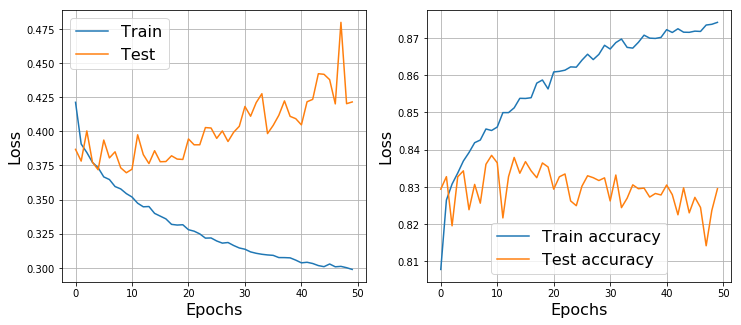

16 0.01 1
Epoch 49... (Train/Test) NLL: 0.219/0.520	Accuracy: 0.907/0.813

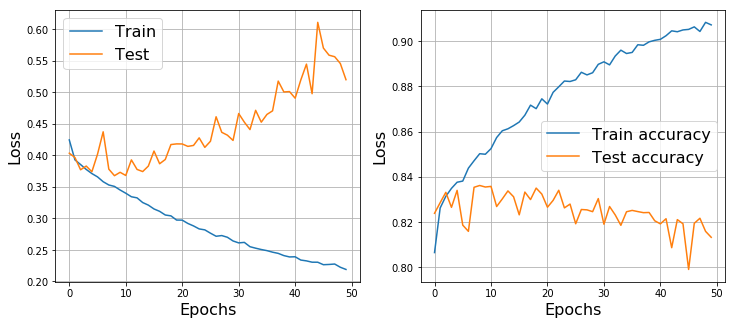

16 0.01 2
Epoch 49... (Train/Test) NLL: 0.266/0.456	Accuracy: 0.891/0.817

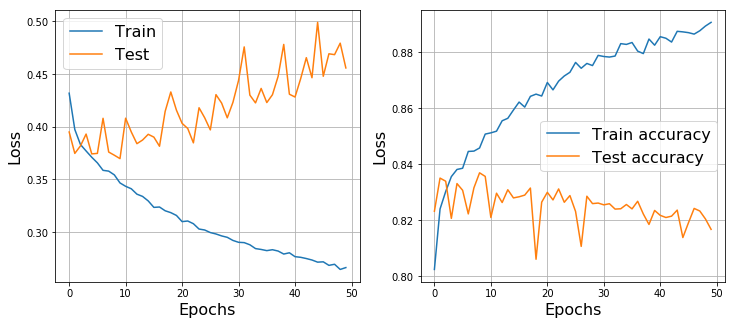

16 0.01 3
Epoch 49... (Train/Test) NLL: 0.340/0.399	Accuracy: 0.855/0.826

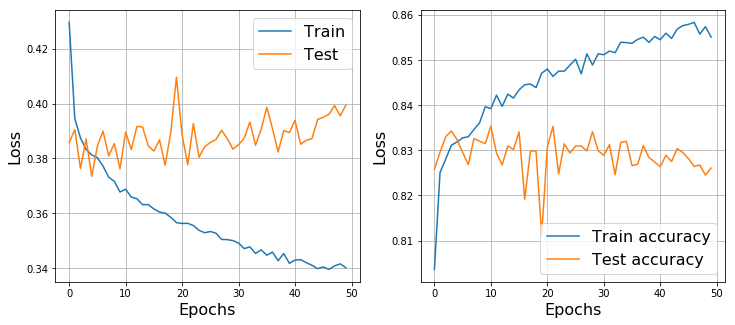

16 0.001 0
Epoch 49... (Train/Test) NLL: 0.219/0.463	Accuracy: 0.911/0.821

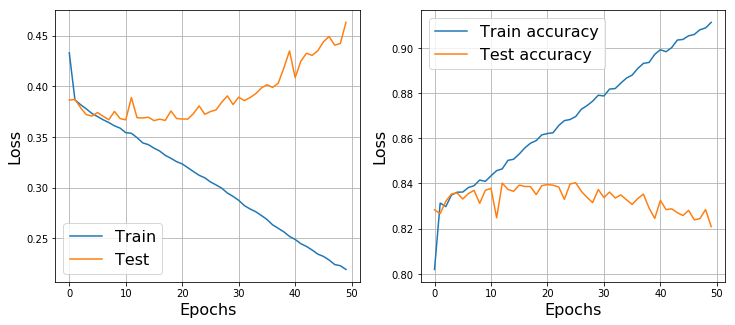

16 0.001 1
Epoch 49... (Train/Test) NLL: 0.077/1.069	Accuracy: 0.970/0.798

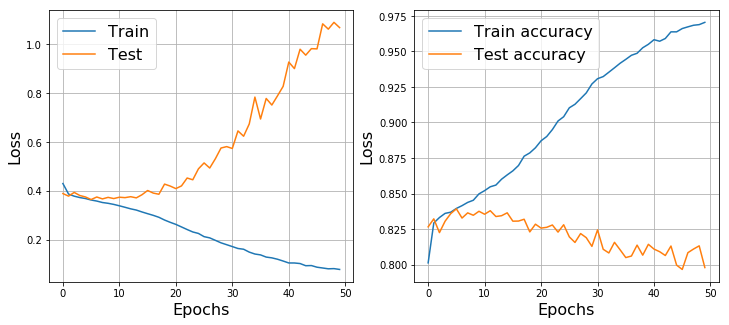

16 0.001 2
Epoch 49... (Train/Test) NLL: 0.152/0.694	Accuracy: 0.939/0.810

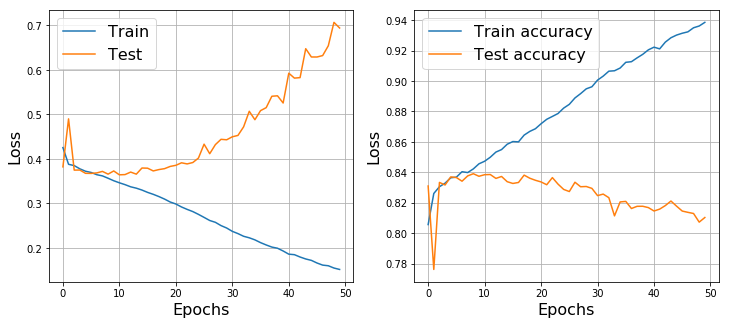

16 0.001 3
Epoch 49... (Train/Test) NLL: 0.182/0.586	Accuracy: 0.924/0.811

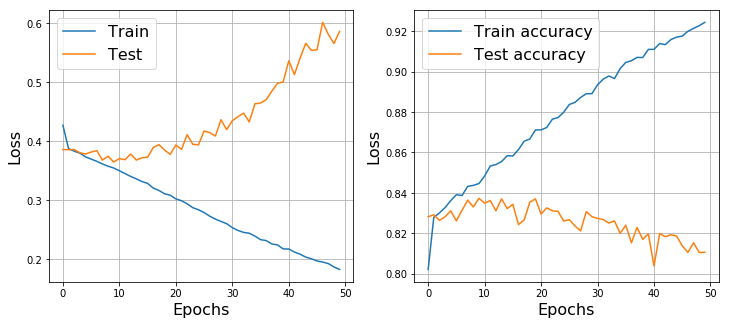

16 0.0001 0
Epoch 49... (Train/Test) NLL: 0.340/0.365	Accuracy: 0.851/0.839

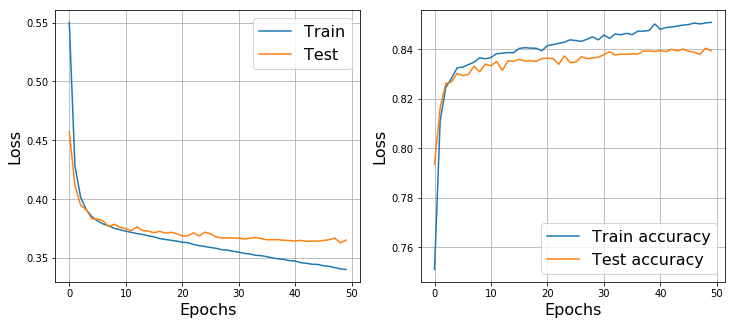

16 0.0001 1
Epoch 49... (Train/Test) NLL: 0.244/0.405	Accuracy: 0.902/0.832

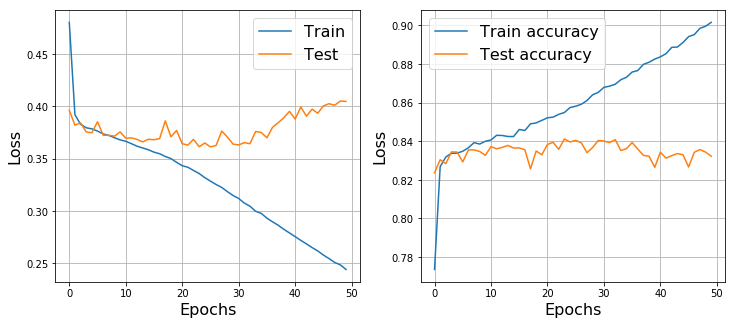

16 0.0001 2
Epoch 49... (Train/Test) NLL: 0.301/0.373	Accuracy: 0.872/0.837

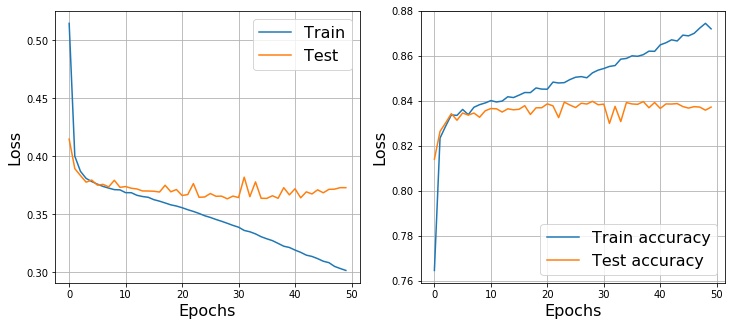

16 0.0001 3
Epoch 49... (Train/Test) NLL: 0.285/0.391	Accuracy: 0.883/0.834

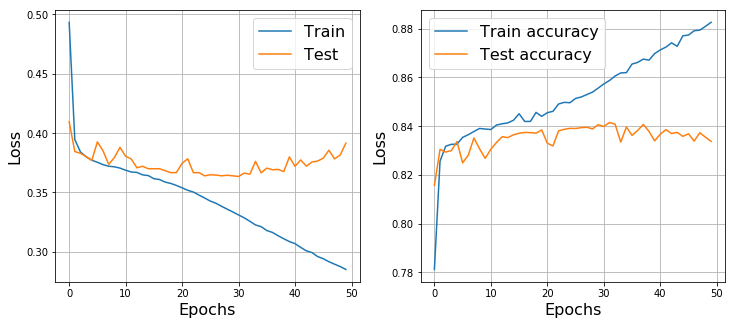

32 0.01 0
Epoch 49... (Train/Test) NLL: 0.299/0.412	Accuracy: 0.874/0.823

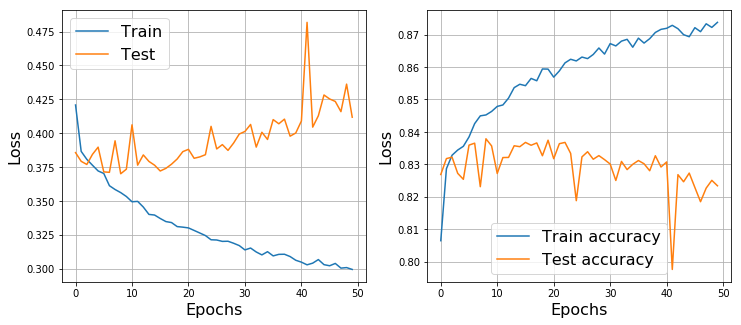

32 0.01 1
Epoch 49... (Train/Test) NLL: 0.290/0.421	Accuracy: 0.880/0.824

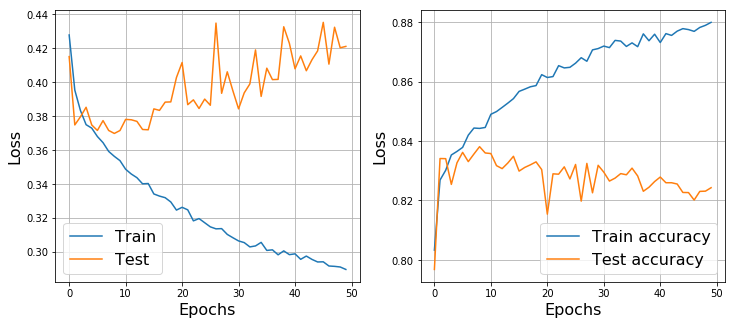

32 0.01 2
Epoch 49... (Train/Test) NLL: 0.215/0.532	Accuracy: 0.911/0.809

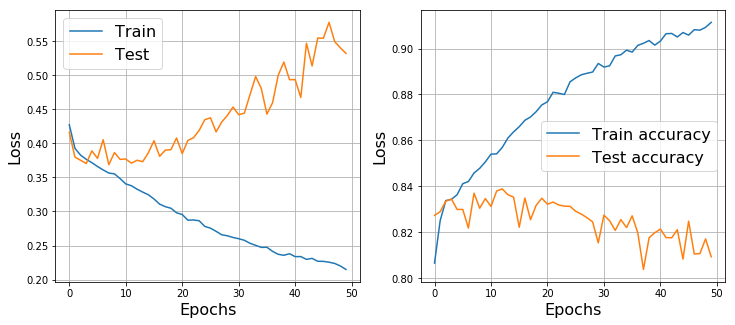

32 0.01 3
Epoch 49... (Train/Test) NLL: 0.240/0.518	Accuracy: 0.900/0.819

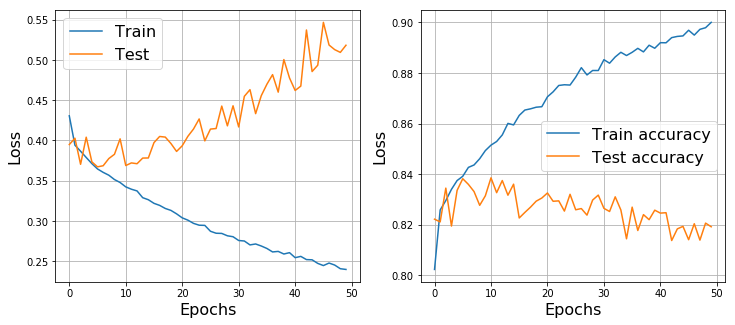

32 0.001 0
Epoch 49... (Train/Test) NLL: 0.301/0.402	Accuracy: 0.874/0.827

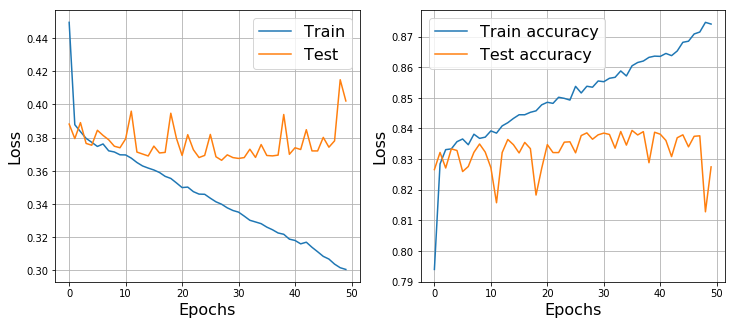

32 0.001 1
Epoch 49... (Train/Test) NLL: 0.072/1.025	Accuracy: 0.973/0.801

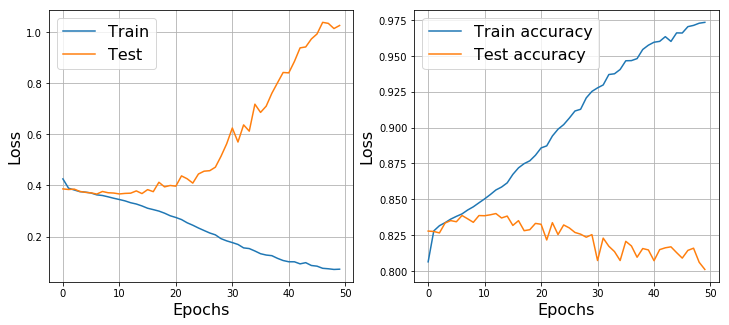

32 0.001 2
Epoch 49... (Train/Test) NLL: 0.168/0.586	Accuracy: 0.930/0.819

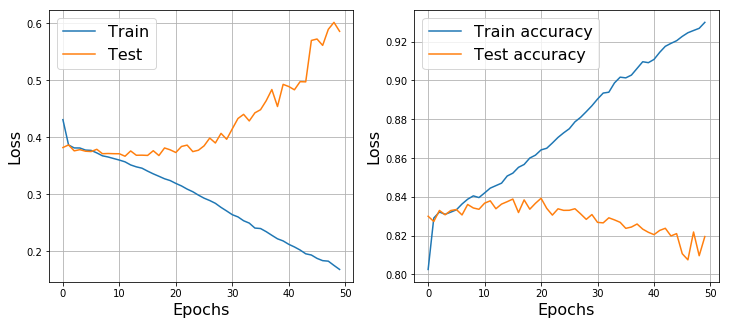

32 0.001 3
Epoch 49... (Train/Test) NLL: 0.164/0.625	Accuracy: 0.934/0.815

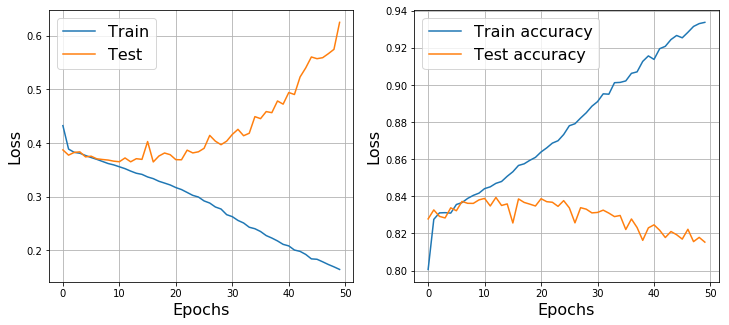

32 0.0001 0
Epoch 49... (Train/Test) NLL: 0.350/0.365	Accuracy: 0.849/0.838

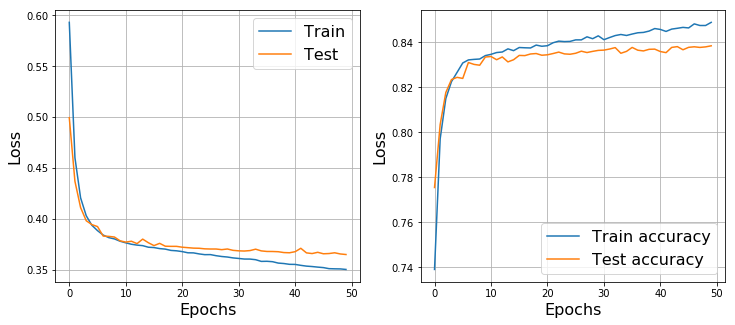

32 0.0001 1
Epoch 49... (Train/Test) NLL: 0.273/0.376	Accuracy: 0.889/0.838

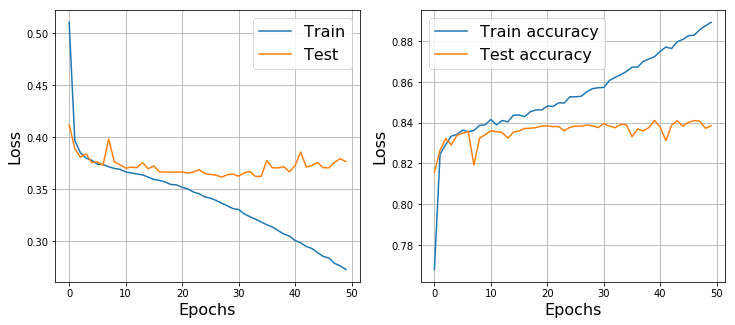

32 0.0001 2
Epoch 49... (Train/Test) NLL: 0.338/0.369	Accuracy: 0.855/0.837

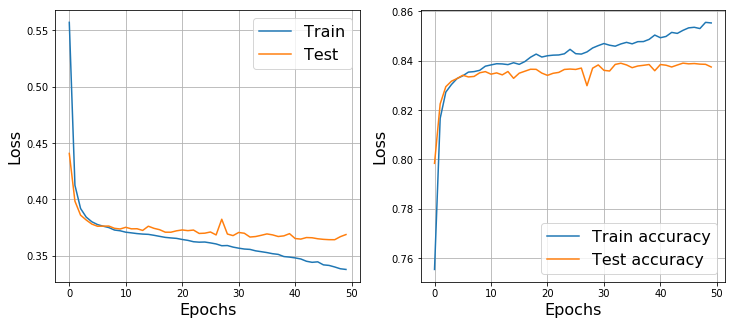

32 0.0001 3
Epoch 49... (Train/Test) NLL: 0.313/0.367	Accuracy: 0.867/0.839

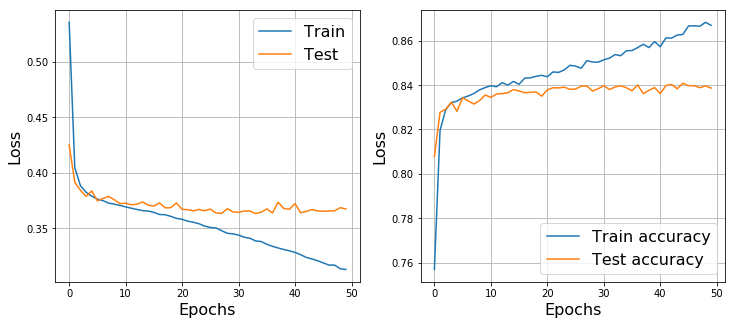

64 0.01 0
Epoch 49... (Train/Test) NLL: 0.187/0.647	Accuracy: 0.925/0.815

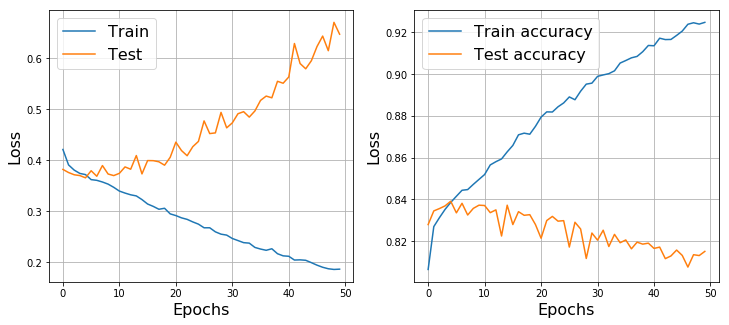

64 0.01 1
Epoch 49... (Train/Test) NLL: 0.219/0.535	Accuracy: 0.906/0.822

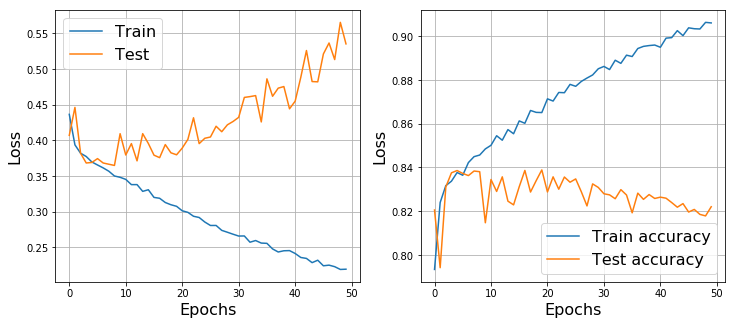

64 0.01 2
Epoch 49... (Train/Test) NLL: 0.211/0.575	Accuracy: 0.907/0.820

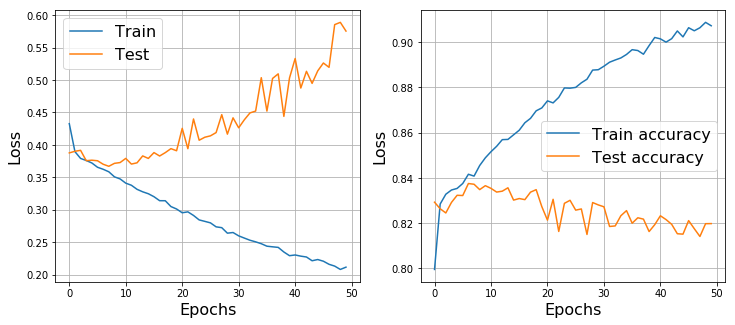

64 0.01 3
Epoch 49... (Train/Test) NLL: 0.219/0.651	Accuracy: 0.905/0.814

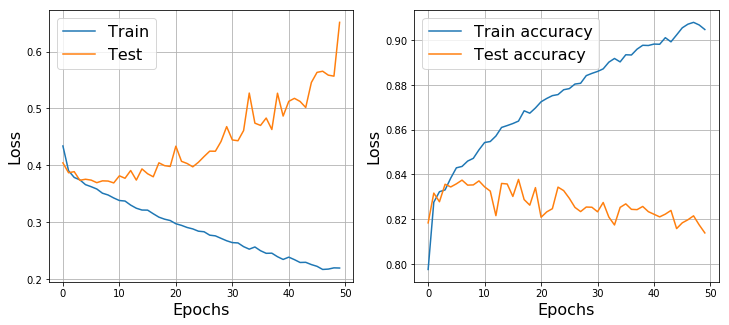

64 0.001 0
Epoch 49... (Train/Test) NLL: 0.308/0.379	Accuracy: 0.870/0.836

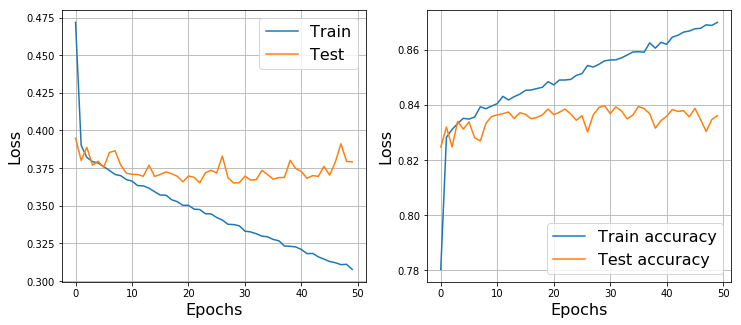

64 0.001 1
Epoch 49... (Train/Test) NLL: 0.078/0.872	Accuracy: 0.971/0.813

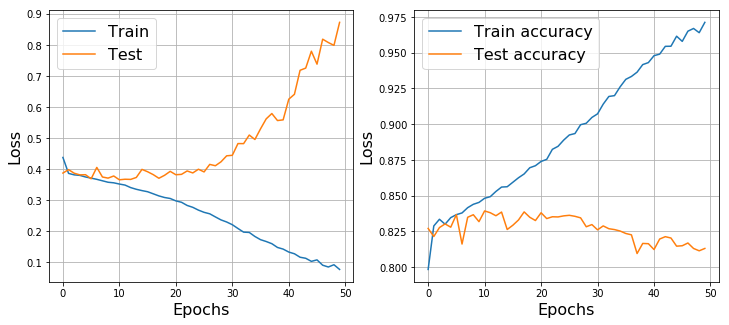

64 0.001 2
Epoch 49... (Train/Test) NLL: 0.242/0.432	Accuracy: 0.896/0.827

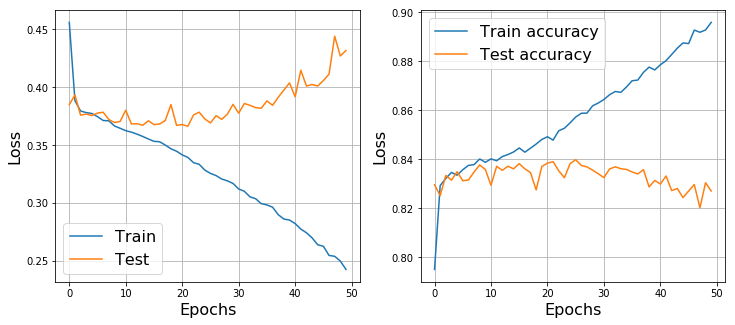

64 0.001 3
Epoch 49... (Train/Test) NLL: 0.251/0.422	Accuracy: 0.893/0.827

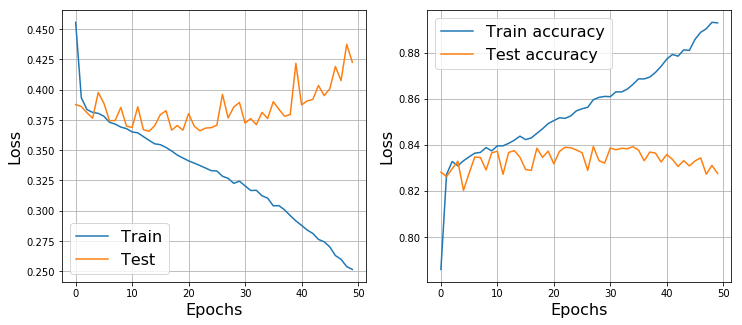

64 0.0001 0
Epoch 49... (Train/Test) NLL: 0.359/0.369	Accuracy: 0.843/0.836

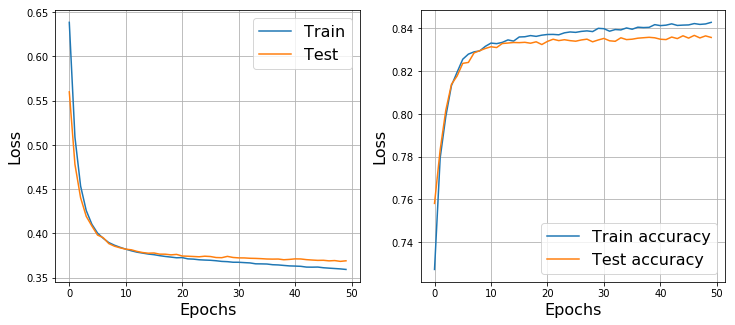

64 0.0001 1
Epoch 49... (Train/Test) NLL: 0.295/0.374	Accuracy: 0.877/0.836

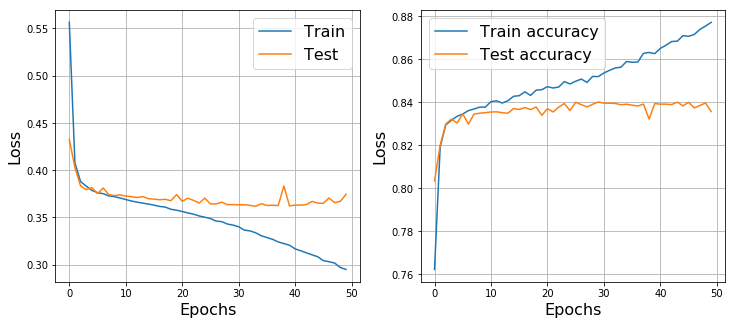

64 0.0001 2
Epoch 49... (Train/Test) NLL: 0.352/0.367	Accuracy: 0.848/0.837

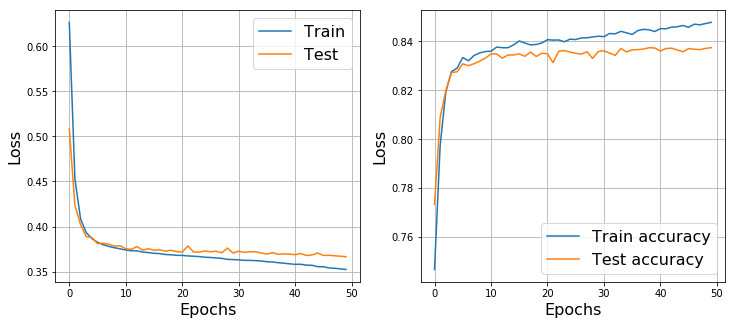

64 0.0001 3
Epoch 49... (Train/Test) NLL: 0.345/0.369	Accuracy: 0.852/0.836

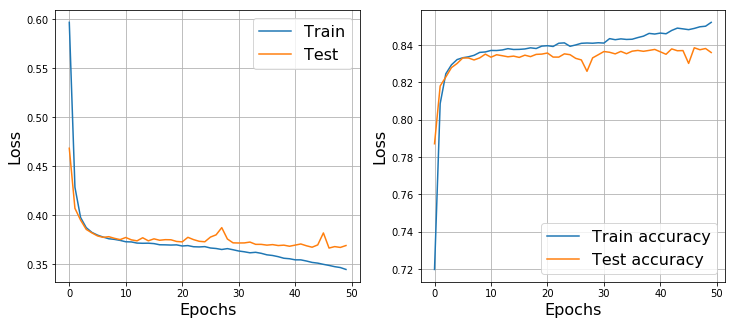

128 0.01 0
Epoch 49... (Train/Test) NLL: 0.215/0.513	Accuracy: 0.912/0.822

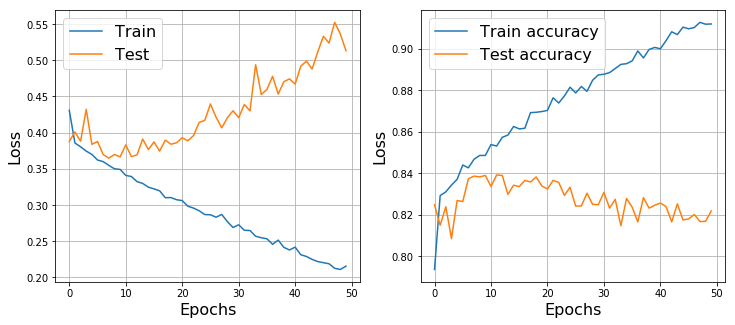

128 0.01 1
Epoch 49... (Train/Test) NLL: 0.160/0.739	Accuracy: 0.933/0.807

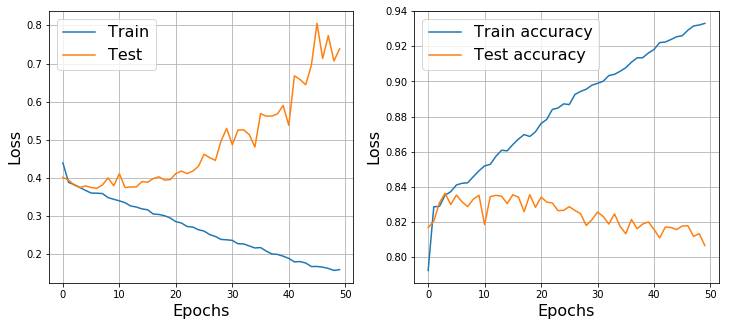

128 0.01 2
Epoch 49... (Train/Test) NLL: 0.164/0.751	Accuracy: 0.930/0.816

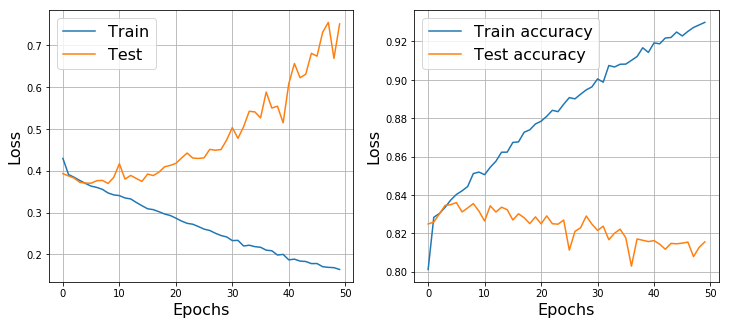

128 0.01 3
Epoch 49... (Train/Test) NLL: 0.173/0.643	Accuracy: 0.928/0.810

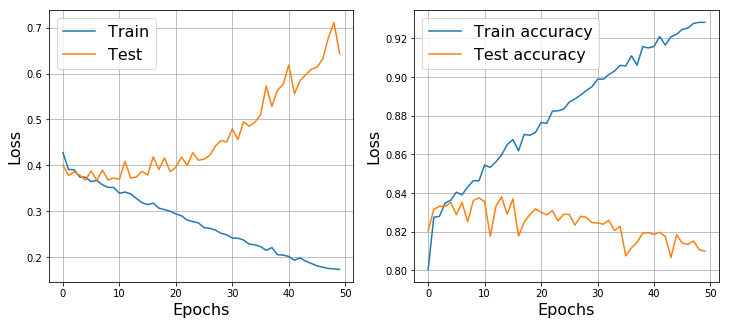

128 0.001 0
Epoch 49... (Train/Test) NLL: 0.287/0.379	Accuracy: 0.880/0.833

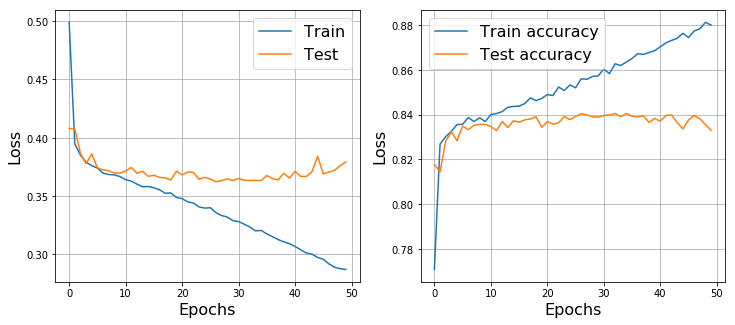

128 0.001 1
Epoch 49... (Train/Test) NLL: 0.132/0.637	Accuracy: 0.949/0.818

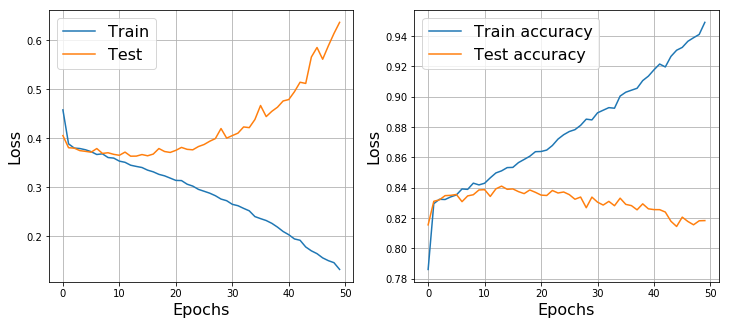

128 0.001 2
Epoch 49... (Train/Test) NLL: 0.268/0.405	Accuracy: 0.888/0.833

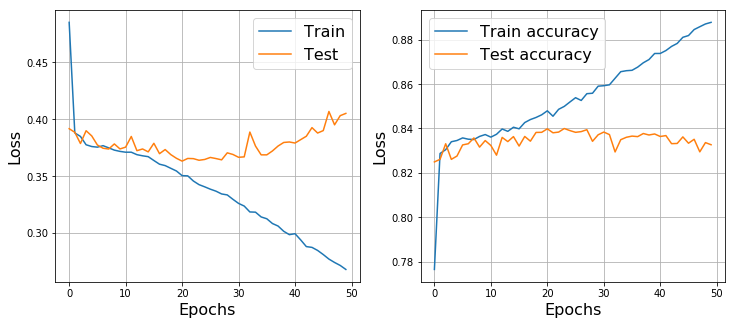

128 0.001 3
Epoch 49... (Train/Test) NLL: 0.261/0.420	Accuracy: 0.891/0.833

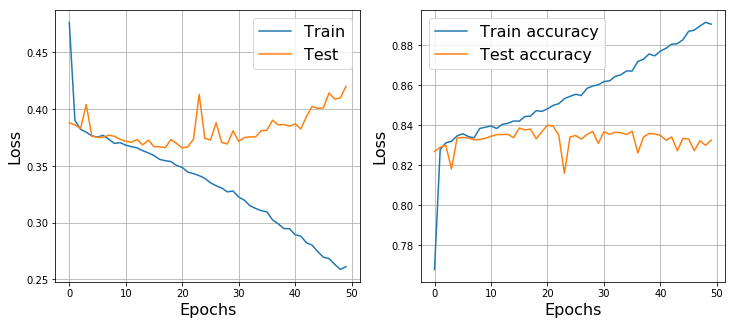

128 0.0001 0
Epoch 49... (Train/Test) NLL: 0.366/0.372	Accuracy: 0.841/0.835

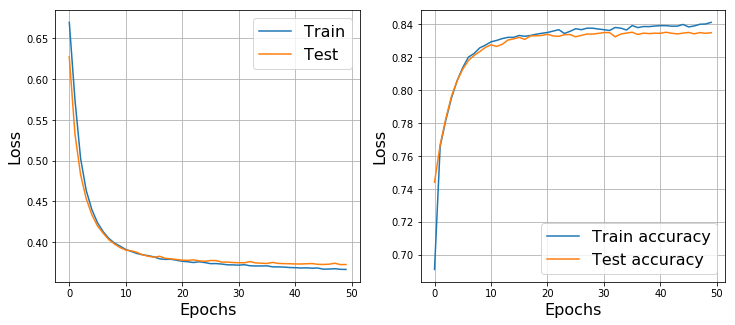

128 0.0001 1
Epoch 49... (Train/Test) NLL: 0.342/0.364	Accuracy: 0.853/0.840

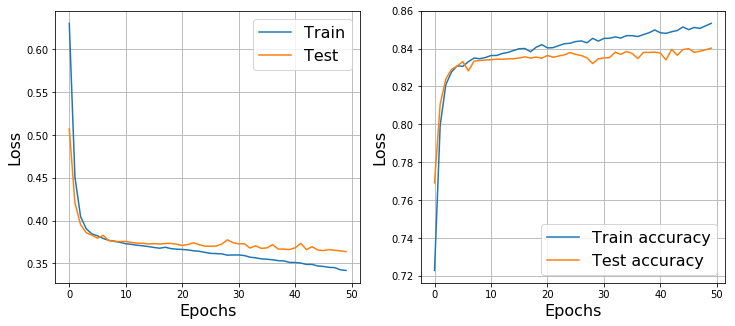

128 0.0001 2
Epoch 49... (Train/Test) NLL: 0.362/0.371	Accuracy: 0.843/0.837

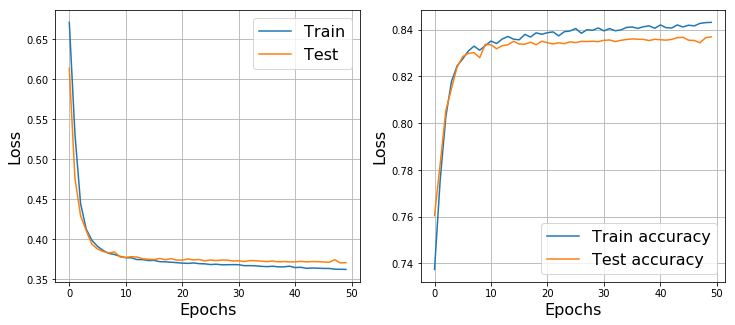

128 0.0001 3
Epoch 49... (Train/Test) NLL: 0.353/0.366	Accuracy: 0.849/0.839

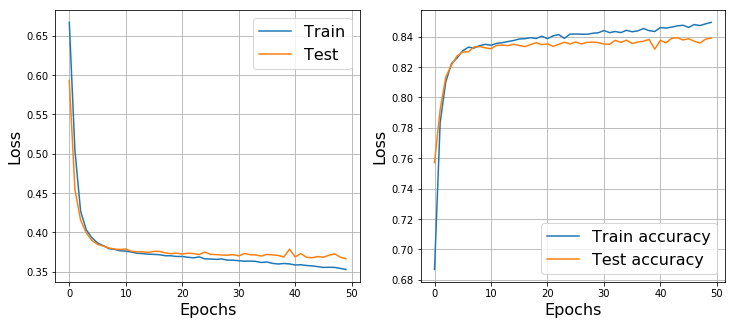

256 0.01 0
Epoch 49... (Train/Test) NLL: 0.189/0.550	Accuracy: 0.924/0.812

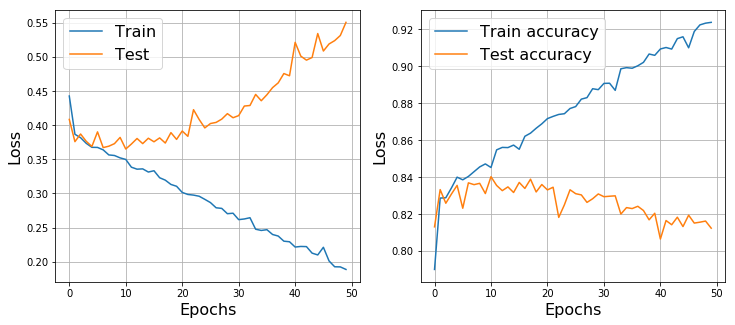

256 0.01 1
Epoch 49... (Train/Test) NLL: 0.107/0.968	Accuracy: 0.956/0.813

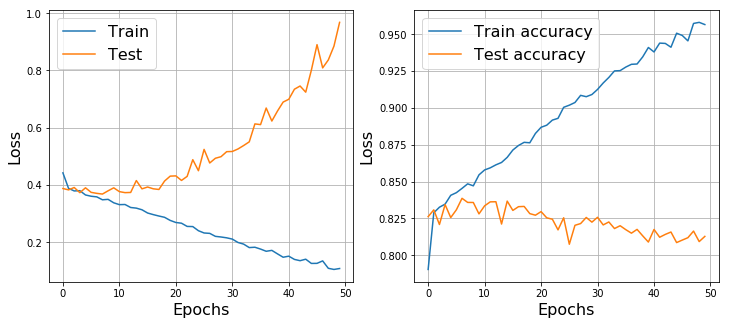

256 0.01 2
Epoch 49... (Train/Test) NLL: 0.201/0.631	Accuracy: 0.916/0.813

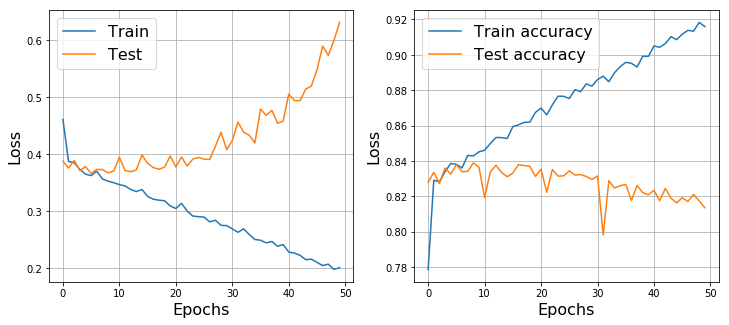

256 0.01 3
Epoch 49... (Train/Test) NLL: 0.230/0.516	Accuracy: 0.902/0.816

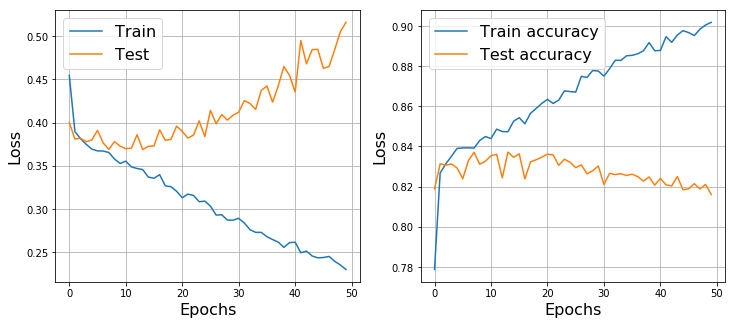

256 0.001 0
Epoch 49... (Train/Test) NLL: 0.333/0.363	Accuracy: 0.857/0.841

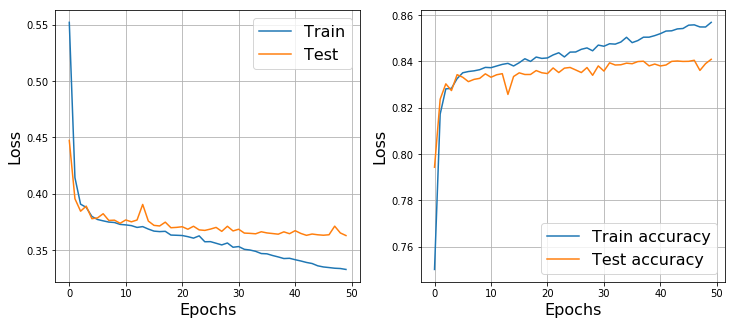

256 0.001 1
Epoch 49... (Train/Test) NLL: 0.237/0.431	Accuracy: 0.904/0.831

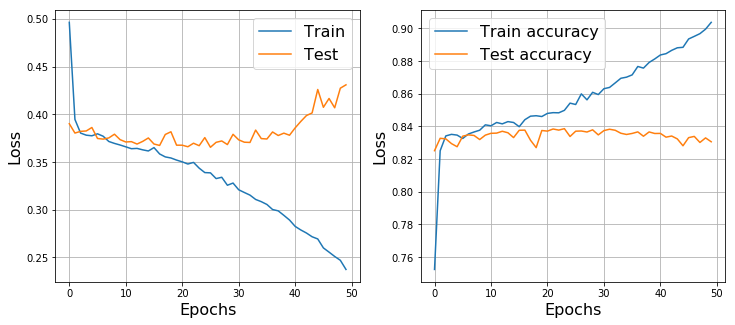

256 0.001 2
Epoch 49... (Train/Test) NLL: 0.293/0.388	Accuracy: 0.877/0.833

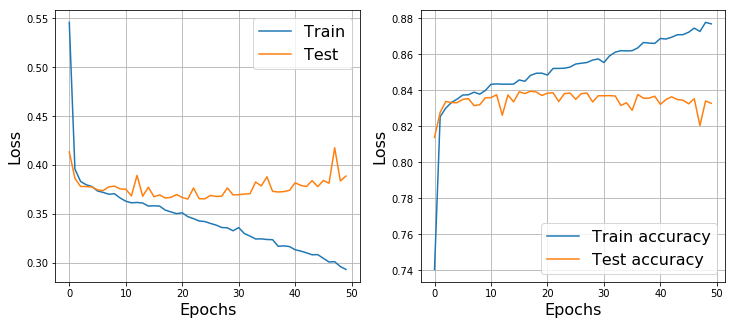

256 0.001 3
Epoch 49... (Train/Test) NLL: 0.302/0.393	Accuracy: 0.871/0.826

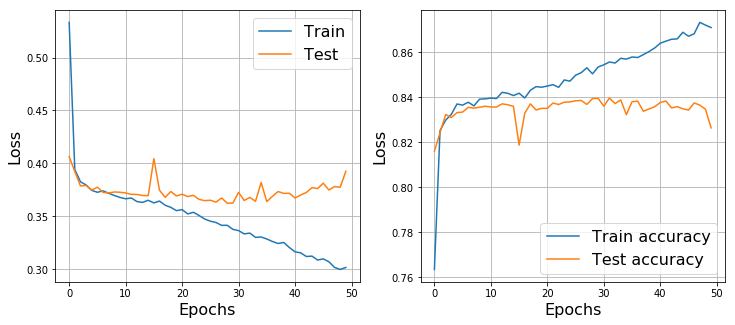

256 0.0001 0
Epoch 49... (Train/Test) NLL: 0.371/0.374	Accuracy: 0.839/0.835

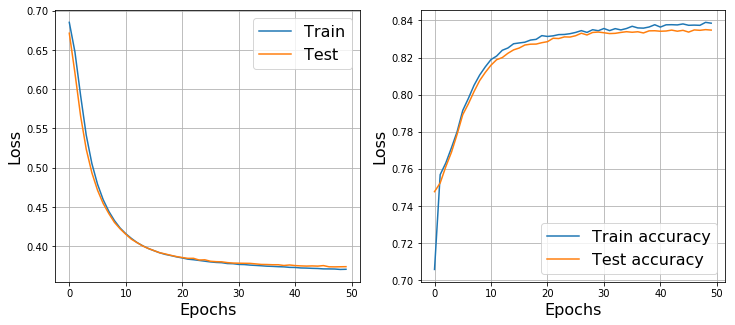

256 0.0001 1
Epoch 49... (Train/Test) NLL: 0.350/0.366	Accuracy: 0.849/0.838

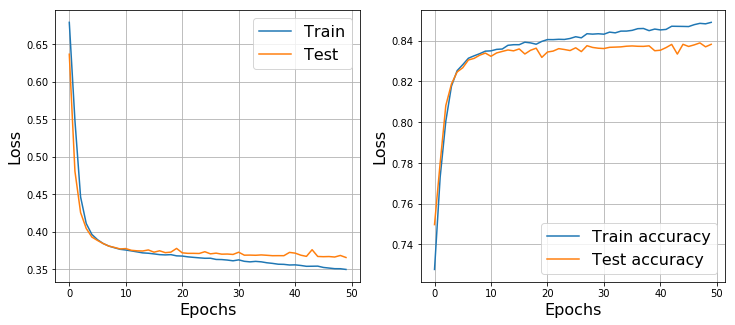

256 0.0001 2
Epoch 49... (Train/Test) NLL: 0.366/0.374	Accuracy: 0.840/0.834

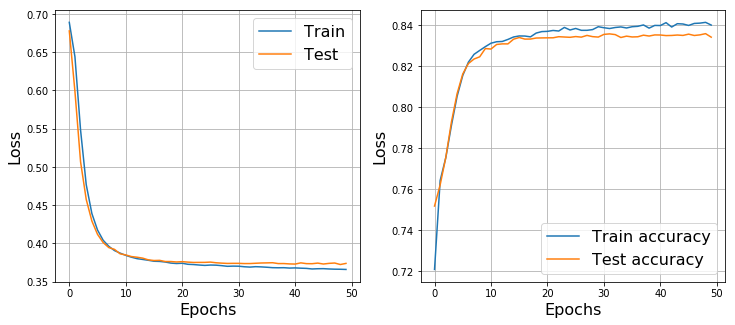

256 0.0001 3
Epoch 49... (Train/Test) NLL: 0.367/0.373	Accuracy: 0.841/0.836

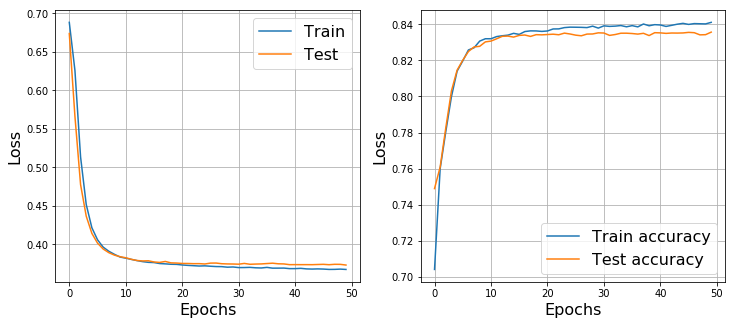

In [131]:
alpha = 1e-5
for batch in [16,32,64,128,256]:
    for lr in [0.01, 0.001, 0.0001]:
        for arch in [0, 1, 2, 3]:
            print(batch, lr, arch)
            
            if arch == 1:
                nn = NeuralNetwork([
                        Linear(300, 300, alpha),
                        ReLU(),
                        Linear(300, 100, alpha),
                        ReLU(),
                        Linear(100, 2, alpha),
                    ])
            if arch == 2:
                nn = NeuralNetwork([
                    Linear(300, 100, alpha),
                    ReLU(),
                    Linear(100, 50, alpha),
                    ReLU(),
                    Linear(50, 2, alpha),
                ])
            if arch ==3:
                nn = NeuralNetwork([
                    Linear(300, 100, alpha),
                    ReLU(),
                    Linear(100, 100, alpha),
                    ReLU(),
                    Linear(100, 2, alpha),
                ])
            if arch == 0:
                nn = NeuralNetwork([
                    Linear(300, 100, alpha),
                    ReLU(),
                    Linear(100, 2, alpha),
                ])

            train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                               vecs_dev_texts, y_dev,
                                                               lr, 50, batch)
            plot_res(train_loss, train_acc, dev_loss, dev_acc)
            

# Подбор регуляризации
Лучший коэффициент 1е-4

128 0.0001 0
Epoch 299... (Train/Test) NLL: 0.257/0.367	Accuracy: 0.900/0.841

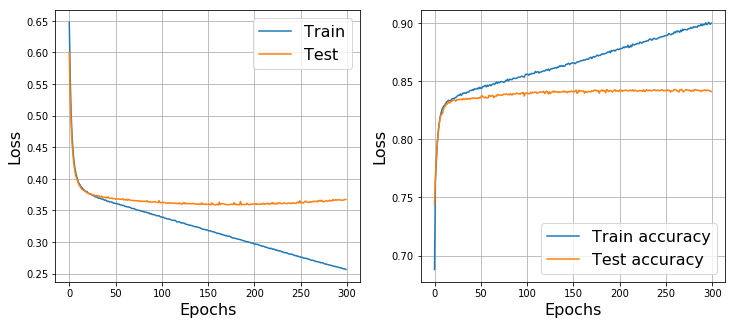

0.8428491709183674 267
256 0.0001 0
Epoch 299... (Train/Test) NLL: 0.297/0.358	Accuracy: 0.878/0.842

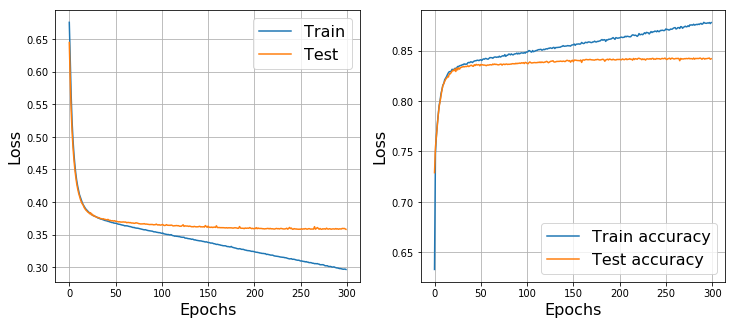

0.8426548074586977 287


In [185]:
alpha = 1e-5
for batch, lr, arch in [(128, 0.0001, 0), 
                        (256, 0.0001, 0),]:
    print(batch, lr, arch)
    if arch == 0:
        nn = NeuralNetwork([
            Linear(300, 100, alpha),
            ReLU(),
            Linear(100, 2, alpha),
        ])

    train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                       vecs_dev_texts, y_dev,
                                                       lr, 300, batch)
    plot_res(train_loss, train_acc, dev_loss, dev_acc)
    print(max(dev_acc), np.argmax(dev_acc))

128 0.0001 0
Epoch 299... (Train/Test) NLL: 0.308/0.363	Accuracy: 0.889/0.842

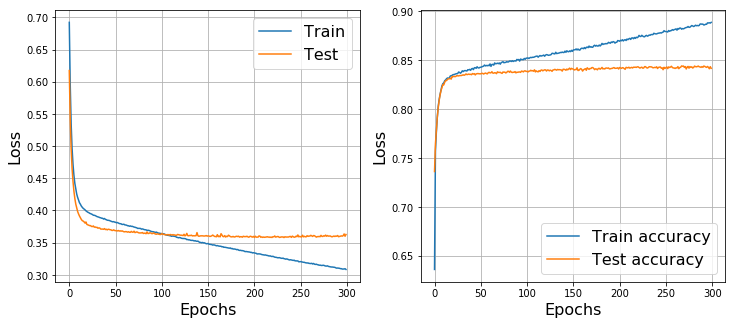

0.8441485969387755 267
256 0.0001 0
Epoch 299... (Train/Test) NLL: 0.328/0.357	Accuracy: 0.872/0.843

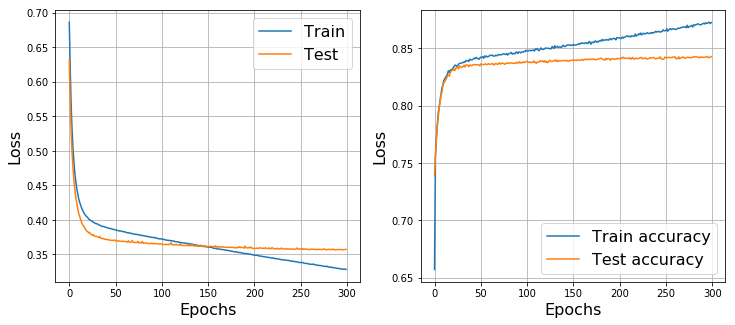

0.8428085519922255 299


In [186]:
alpha = 1e-4
for batch, lr, arch in [(128, 0.0001, 0), 
                        (256, 0.0001, 0),]:
    print(batch, lr, arch)
    if arch == 0:
        nn = NeuralNetwork([
            Linear(300, 100, alpha),
            ReLU(),
            Linear(100, 2, alpha),
        ])

    train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                       vecs_dev_texts, y_dev,
                                                       lr, 300, batch)
    plot_res(train_loss, train_acc, dev_loss, dev_acc)
    print(max(dev_acc), np.argmax(dev_acc))

128 0.0001 0
Epoch 299... (Train/Test) NLL: 0.414/0.363	Accuracy: 0.850/0.839

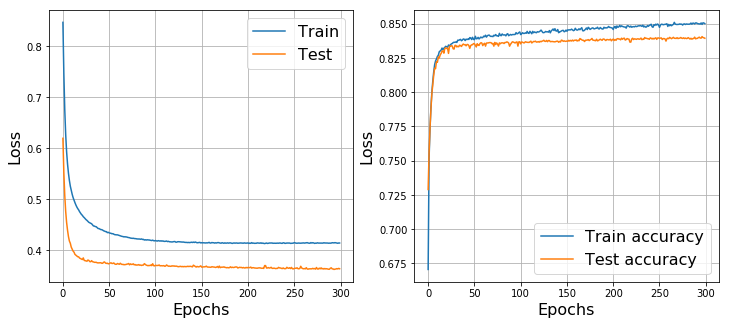

0.8406010841836735 296
256 0.0001 0
Epoch 299... (Train/Test) NLL: 0.413/0.364	Accuracy: 0.847/0.839

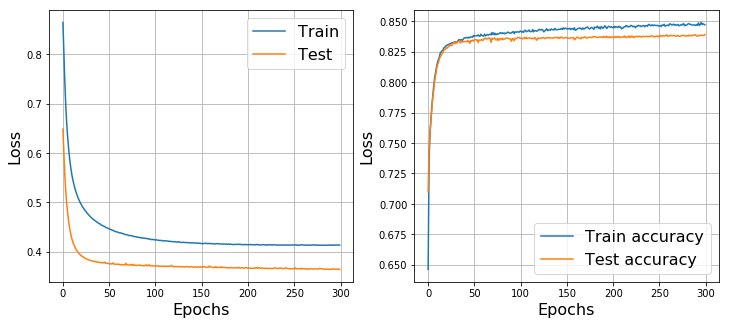

0.8390256772351798 299


In [187]:
alpha = 1e-3
for batch, lr, arch in [(128, 0.0001, 0), 
                        (256, 0.0001, 0),]:
    print(batch, lr, arch)
    if arch == 0:
        nn = NeuralNetwork([
            Linear(300, 100, alpha),
            ReLU(),
            Linear(100, 2, alpha),
        ])

    train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                       vecs_dev_texts, y_dev,
                                                       lr, 300, batch)
    plot_res(train_loss, train_acc, dev_loss, dev_acc)
    print(max(dev_acc), np.argmax(dev_acc))

# Подбор функции активации
Лучшая ReLU

128 0.0001 0
Epoch 299... (Train/Test) NLL: 0.357/0.367	Accuracy: 0.848/0.838

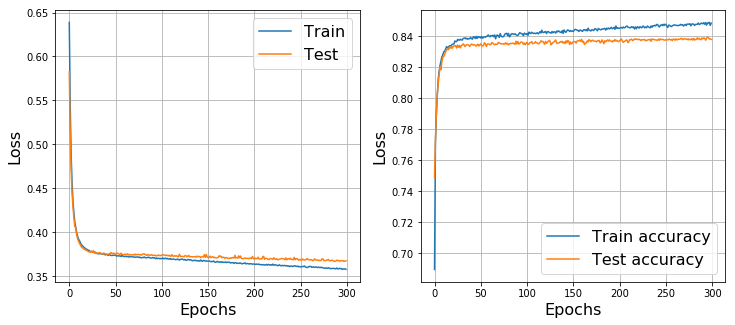

0.839453125 295
256 0.0001 0
Epoch 299... (Train/Test) NLL: 0.363/0.369	Accuracy: 0.846/0.837

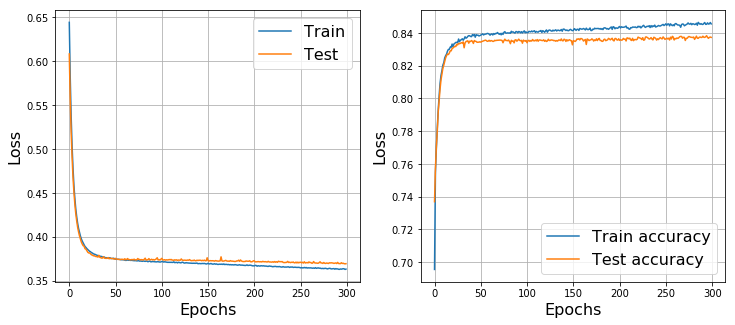

0.8384069029397474 294


In [191]:
alpha = 1e-5
for batch, lr, arch in [(128, 0.0001, 0), 
                        (256, 0.0001, 0),]:
    print(batch, lr, arch)
    if arch == 0:
        nn = NeuralNetwork([
            Linear(300, 100, alpha),
            ELU(),
            Linear(100, 2, alpha),
        ])

    train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                       vecs_dev_texts, y_dev,
                                                       lr, 300, batch)
    plot_res(train_loss, train_acc, dev_loss, dev_acc)
    print(max(dev_acc), np.argmax(dev_acc))

128 0.0001 0
Epoch 299... (Train/Test) NLL: 0.377/0.374	Accuracy: 0.841/0.836

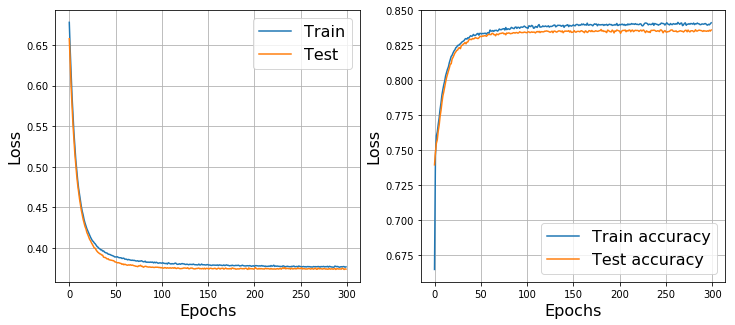

0.8364317602040817 180
256 0.0001 0
Epoch 299... (Train/Test) NLL: 0.378/0.374	Accuracy: 0.841/0.836

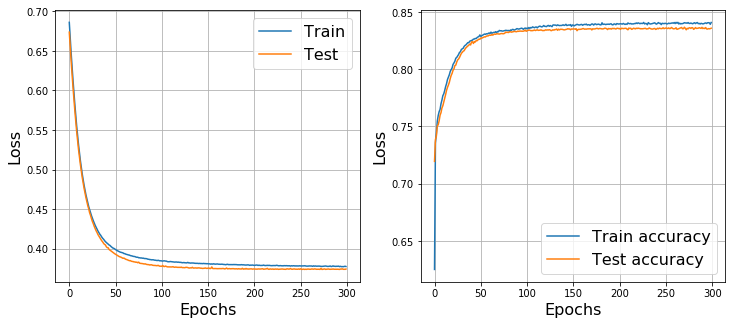

0.8365562742954324 270


In [192]:
alpha = 1e-5
for batch, lr, arch in [(128, 0.0001, 0), 
                        (256, 0.0001, 0),]:
    print(batch, lr, arch)
    if arch == 0:
        nn = NeuralNetwork([
            Linear(300, 100, alpha),
            Sigmoidd(),
            Linear(100, 2, alpha),
        ])

    train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts, y_train, 
                                                       vecs_dev_texts, y_dev,
                                                       lr, 300, batch)
    plot_res(train_loss, train_acc, dev_loss, dev_acc)
    print(max(dev_acc), np.argmax(dev_acc))

# word2vec
Есть небольшое улучшение на 0.003 в точности

In [18]:
def load_word2vec(dim=300):
    word2idx = {}
    idx2word = {}
    vecs = {}
    file_name = 'enwiki_20180420_{}d.txt'.format(dim)
    word2vec_path = os.path.join(word2vec_dir, file_name)
    for idx, line in tqdm_notebook(enumerate(open(word2vec_path, 'r', encoding='utf8')), total=4530030):
        word, vec = line.split(' ', 1)
        if word in vocab:
            word2idx[word] = idx
            idx2word[idx] = word
            vecs[idx] = np.array(list(map(float, vec.split())))
    return word2idx, idx2word, vecs

In [19]:
word2idx2, idx2word2, word2vec = load_word2vec(300)
len(word2idx2), len(idx2word2), len(word2vec)

(67135, 67135, 67135)

In [20]:
cleaned_train_texts_w2v = [clean(r, word2idx2) for r in tokenized_train_texts]
cleaned_dev_texts_w2v = [clean(r, word2idx2) for r in tokenized_dev_texts]
cleaned_test_texts_w2v = [clean(r, word2idx2) for r in tokenized_test_texts]

In [21]:
vecs_train_texts_w2v = np.array([vectorize(r, word2vec, word2idx2) for r in cleaned_train_texts_w2v])
vecs_dev_texts_w2v = np.array([vectorize(r, word2vec, word2idx2) for r in cleaned_dev_texts_w2v])
vecs_test_texts_w2v = np.array([vectorize(r, word2vec, word2idx2) for r in cleaned_test_texts_w2v])

128 0.0001 0
Epoch 299... (Train/Test) NLL: 0.336/0.351	Accuracy: 0.870/0.846

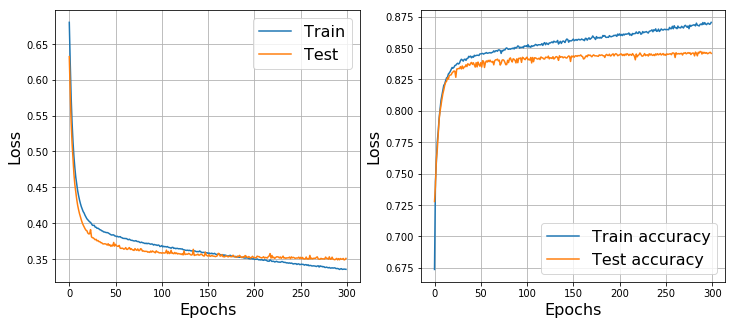

0.8472576530612245 287
256 0.0001 0
Epoch 299... (Train/Test) NLL: 0.350/0.352	Accuracy: 0.860/0.846

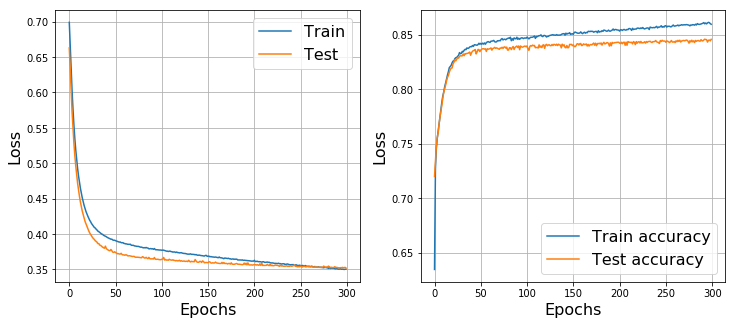

0.8458246021622935 292


In [25]:
alpha = 1e-4
for batch, lr, arch in [(128, 0.0001, 0), 
                        (256, 0.0001, 0),]:
    print(batch, lr, arch)
    if arch == 0:
        nn = NeuralNetwork([
            Linear(300, 100, alpha),
            ReLU(),
            Linear(100, 2, alpha),
        ])

    train_loss, train_acc, dev_loss, dev_acc = train_(nn, vecs_train_texts_w2v, y_train, 
                                                       vecs_dev_texts_w2v, y_dev,
                                                       lr, 300, batch)
    plot_res(train_loss, train_acc, dev_loss, dev_acc)
    print(max(dev_acc), np.argmax(dev_acc))

# Итог

1. Реализован Adam
2. Проведены эксперименты с параметрами, архитектурой 
3. Проведен эксперимент с векторами word2vec